In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc

In [2]:
def prettify_ax(ax):
    """
    Nifty function we can use to make our axes more pleasant to look at
    """
    for spine in ax.spines.itervalues():
        spine.set_visible(False)
    ax.set_frameon=True
    ax.patch.set_facecolor('#eeeeef')
    ax.grid('on', color='w', linestyle='-', linewidth=1)
    ax.tick_params(direction='out')
    ax.set_axisbelow(True)
    
def simple_ax(figsize=(6,4), **kwargs):
    """
    Shortcut to make and 'prettify' a simple figure with 1 axis
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, **kwargs)
    prettify_ax(ax)
    return fig, ax

matplotlib.rcParams.update({'font.size': 14})

## Clean data

In [3]:
# clean data
data = pd.read_csv('original_data.csv', index_col=0)
data = data.drop('AppointmentID', axis=1)
data.rename(columns = {'Hipertension':'Hypertension','Handcap':'Handicap','No-show':'Noshow'}, inplace=True)
data.Gender = [1 if i=='M' else 0 for i in data.Gender]
data.Noshow = [1 if i=='Yes' else 0 for i in data.Noshow]
data.ScheduledDay = data.ScheduledDay.apply(np.datetime64)
data.AppointmentDay = data.AppointmentDay.apply(np.datetime64)
data['ScheduledHour'] = data.ScheduledDay.apply(lambda x: x.hour)
data['Scheduled'] = data.ScheduledDay.apply(lambda x: x.date())
data['Appointment'] = data.AppointmentDay.apply(lambda x: x.date())
data['DaysSchedToAppt'] = data.Appointment - data.Scheduled
data.DaysSchedToAppt = data.DaysSchedToAppt.apply(lambda x: x.days)
data = data.drop(['Scheduled', 'Appointment', 'ScheduledDay', 'AppointmentDay'], axis=1)
data = data[(data.Age>=0) & (data.Age<=95)]
data.to_csv('cleaned_data.csv')
print(data.shape)
data.head()

(110480, 12)


,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,Noshow,ScheduledHour,DaysSchedToAppt
PatientId,,,,,,,,,,,,
2.987250e+13,0,62,JARDIM DA PENHA,0,1,0,0,0,0,0,18,0
5.589978e+14,1,56,JARDIM DA PENHA,0,0,0,0,0,0,0,16,0
4.262962e+12,0,62,MATA DA PRAIA,0,0,0,0,0,0,0,16,0
8.679512e+11,0,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,17,0
8.841186e+12,0,56,JARDIM DA PENHA,0,1,1,0,0,0,0,16,0


In [4]:
print ("{}% of the patients were no-shows.".format(round(100*sum(data.Noshow)/data.shape[0],2)))

20.2% of the patients were no-shows.


In [5]:
# get neighborhood dummy variables
data = pd.get_dummies(data, columns=['Neighbourhood'])
print(data.shape)

(110480, 92)


## Inspect features

In [6]:
def feature_probs(data, feature):
    featurevals, probs = sorted(set(data[feature])), []
    for featureval in featurevals:
        df = data[data[feature] == featureval]
        prob = df.Noshow.sum()/df.shape[0]
        probs.append(prob)
    return pd.DataFrame({feature:featurevals, 'no-show prob':probs})

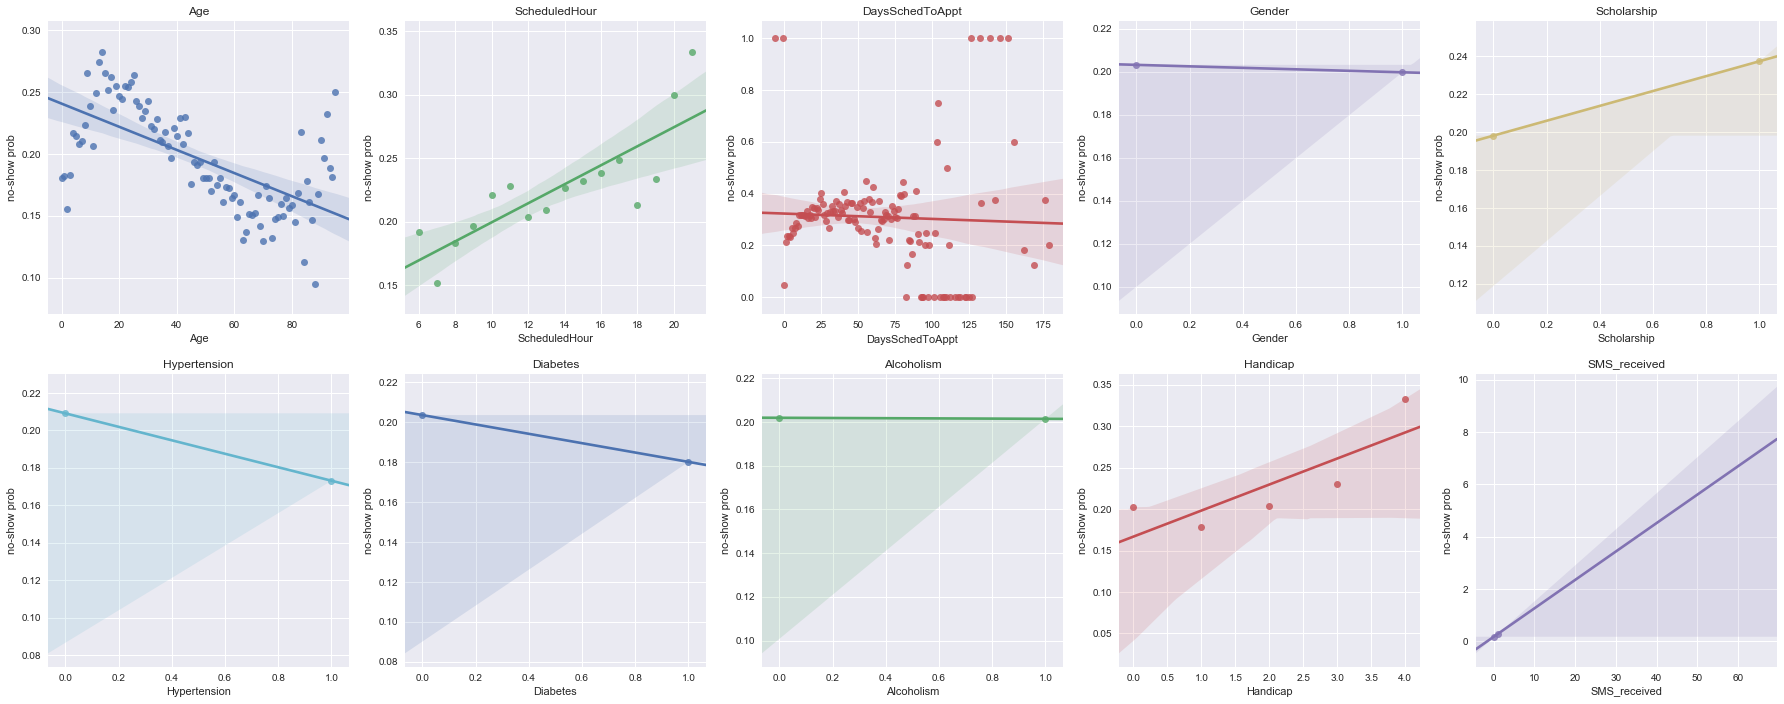

In [35]:
f, axarr = plt.subplots(2,5, figsize=(25,10))
for e,col in enumerate(['Age', 'ScheduledHour', 'DaysSchedToAppt', 'Gender', 'Scholarship', \
                        'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received']):
    ax = axarr.flat[e]
    sns.regplot(x=col, y='no-show prob', data=feature_probs(data, col), ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.savefig('Figures/features.pdf')
plt.show()

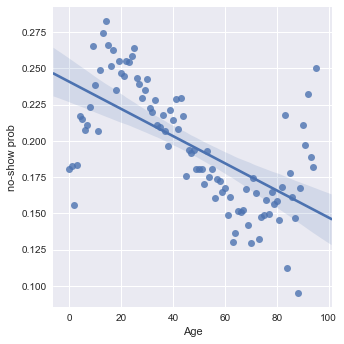

In [38]:
sns.lmplot(x='Age', y='no-show prob', data=feature_probs(data, 'Age'))
plt.savefig('Figures/age_feature.pdf')
plt.show()

## Split data

In [7]:
# train on 80%
train_idx = np.random.choice(range(data.shape[0]), int(0.8*data.shape[0]))
traindata = data.iloc[train_idx,:]
testdata = data.iloc[list(set(range(data.shape[0]))-set(train_idx)),:]
ytrain = traindata.Noshow
Xtrain = traindata.drop('Noshow', axis=1)
ytest = testdata.Noshow
Xtest = testdata.drop('Noshow', axis=1)
print("Xtrain shape:", Xtrain.shape)
print("ytrain shape:", ytrain.shape)
print("Xtest shape:", Xtest.shape)
print("ytest shape:", ytest.shape)

Xtrain shape: (88384, 91)
ytrain shape: (88384,)
Xtest shape: (49483, 91)
ytest shape: (49483,)


## Learn

Logistic score: 0.793694020818


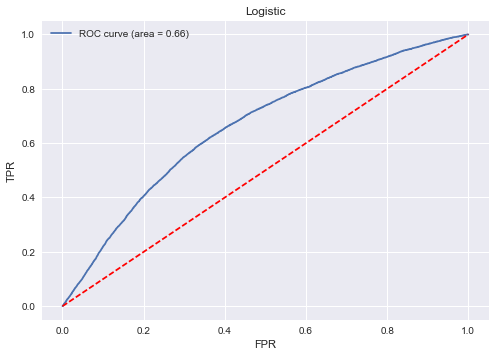

In [8]:
# logistic regression
model = LogisticRegression()
model.fit(Xtrain, ytrain)
preds = model.predict_proba(Xtest)[:,1]
fpr, tpr, thresholds = roc_curve(ytest, preds)
model_auc = auc(fpr,tpr)

print("Logistic score:", model.score(Xtest, ytest))
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(model_auc))
plt.plot([0,1], [0,1], '--', c='r')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Logistic')
plt.legend()
plt.savefig('Figures/logistic.pdf')
plt.show()

Decision tree score: 0.730058013053


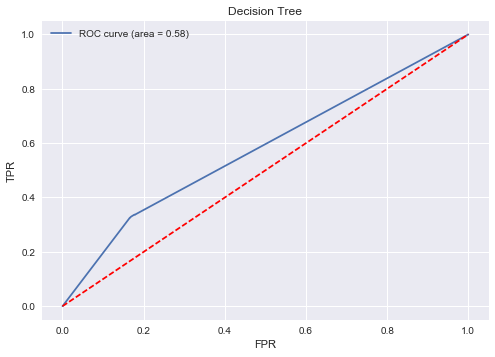

In [114]:
# decision tree
model = DecisionTreeClassifier()
model.fit(Xtrain, ytrain)
preds = model.predict_proba(Xtest)[:,1]
fpr, tpr, thresholds = roc_curve(ytest, preds)
model_auc = auc(fpr,tpr)

print("Decision tree score:", model.score(Xtest, ytest))
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(model_auc))
plt.plot([0,1], [0,1], '--', c='r')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Decision Tree')
plt.legend()
plt.savefig('Figures/decisiontree.pdf')
plt.show()

Random forest score: 0.781625171219


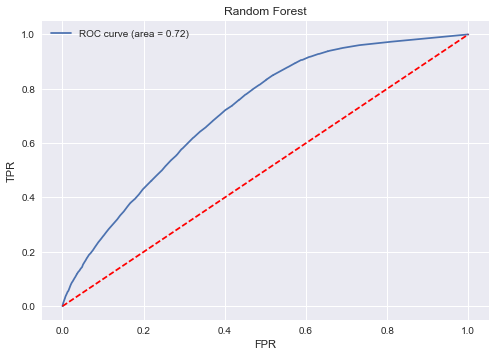

In [112]:
# random forest
model = RandomForestClassifier(n_estimators=100)
model.fit(Xtrain, ytrain)
preds = model.predict_proba(Xtest)[:,1]
fpr, tpr, thresholds = roc_curve(ytest, preds)
model_auc = auc(fpr,tpr)

print("Random forest score:", model.score(Xtest, ytest))
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(model_auc))
plt.plot([0,1], [0,1], '--', c='r')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Random Forest')
plt.legend()
plt.savefig('Figures/random_forest.pdf')
plt.show()

KNN score: 0.755754501546


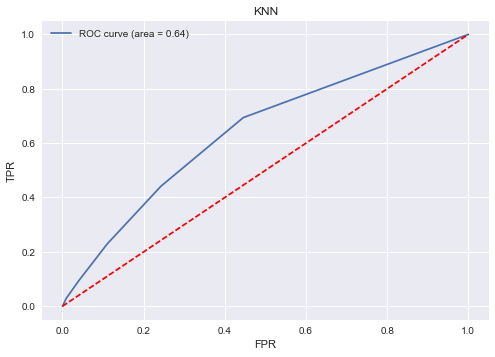

In [10]:
# KNN
model = KNeighborsClassifier()
model.fit(Xtrain, ytrain)
preds = model.predict_proba(Xtest)[:,1]
fpr, tpr, thresholds = roc_curve(ytest, preds)
model_auc = auc(fpr,tpr)

print("KNN score:", model.score(Xtest, ytest))
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(model_auc))
plt.plot([0,1], [0,1], '--', c='r')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('KNN')
plt.legend()
plt.savefig('Figures/knn.pdf')
plt.show()

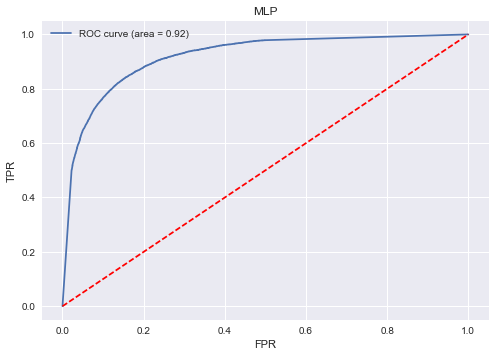

In [19]:
# MLP
model = MLPClassifier()
model.fit(Xtrain, ytrain)
preds = model.predict_proba(Xtest)[:,1]
fpr, tpr, thresholds = roc_curve(ytest, ab)
model_auc = auc(fpr,tpr)

print("MLP score:", model.score(Xtest, ytest))
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(model_auc))
plt.plot([0,1], [0,1], '--', c='r')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('MLP')
plt.legend()
plt.savefig('Figures/mlp.pdf')
plt.show()